In [ ]:
import pickle
result_root_2A = f"experiment_result/FedAvgM_Diffusion_2A_20250806_005337/intermediate_results"
for i in range(10):
    with open(f"{result_root_2A}/CF_{i}_result.pkl", "rb") as f:
        result = pickle.load(f)
        history_obj = result["history"]
        
        # Access diffusion_loss from metrics_centralized
        print("ssim:", history_obj.metrics_centralized["ssim"][-1][1])

ssim: 0.9166019558906555
ssim: 0.9210359454154968
ssim: 0.3460482954978943
ssim: 0.936425507068634
ssim: 0.895470142364502
ssim: 0.878612756729126
ssim: 0.6202558279037476
ssim: 0.895199179649353
ssim: 0.8271270990371704
ssim: 0.2616521120071411


In [20]:
import pickle
result_root_2A = f"experiment_result/FedAvgM_Diffusion_2A_20250806_005337/intermediate_results"
for i in range(10):
    with open(f"{result_root_2A}/CV_{i}_result.pkl", "rb") as f:
        result = pickle.load(f)
        history_obj = result["history"]
        
        # Access diffusion_loss from metrics_centralized
        print("ssim:", history_obj.metrics_centralized["ssim"][-1][1])

ssim: 0.6860289573669434
ssim: 0.9451403021812439
ssim: 0.9181747436523438
ssim: 0.8302531242370605
ssim: 0.6148689389228821
ssim: 0.8870447874069214
ssim: 0.931169867515564
ssim: 0.4751071631908417
ssim: 0.9097065329551697
ssim: 0.8960686326026917


In [15]:
import pickle
import glob
result_root_2A = result_files = glob.glob("hpc_result/FedAvgM_Diffusion_2C_*/aggregated_results.pkl")
if result_files:
    result_root_2A = result_files[0] 
with open(f"{result_root_2A}", "rb") as f:
    result = pickle.load(f)
    print(result['overall_history']['metrics_centralized'].keys())
    history_obj = result['overall_history']['metrics_centralized']
    # Access diffusion_loss from metrics_centralized
    print("ssim:", history_obj["ssim"])

dict_keys(['seismic_loss', 'diffusion_loss', 'mae', 'rmse', 'ssim'])
ssim: 0.7661693423936847


In [2]:
import pickle
import glob
result_root_2A = result_files = glob.glob("hpc_result/FedAvgM_Diffusion_2C_*/aggregated_results.pkl")
if result_files:
    result_root_2A = result_files[0] 
with open(f"{result_root_2A}", "rb") as f:
    result = pickle.load(f)
    print(result['individual_runs'][0]['history'].metrics_centralized["ssim"])
    print(result['individual_runs'][0]['history'].metrics_centralized["rmse"])
    print(result['individual_runs'][0]['history'].metrics_centralized["mae"])
    

[(0, 0.5602846741676331), (1, 0.5481760501861572), (2, 0.4927375614643097), (3, 0.43980464339256287), (4, 0.4089818298816681), (5, 0.39311912655830383), (6, 0.3821653425693512), (7, 0.37299445271492004), (8, 0.36273208260536194), (9, 0.3559498190879822), (10, 0.3529704809188843), (11, 0.3460576832294464), (12, 0.3354269862174988), (13, 0.32732638716697693), (14, 0.32493525743484497), (15, 0.3235000669956207), (16, 0.3203713595867157), (17, 0.31757989525794983), (18, 0.31745272874832153), (19, 0.31951045989990234), (20, 0.318697988986969), (21, 0.3178713321685791), (22, 0.32073381543159485), (23, 0.32575926184654236), (24, 0.33097606897354126), (25, 0.3370479941368103), (26, 0.3449159562587738), (27, 0.35104259848594666), (28, 0.3568563163280487), (29, 0.3586035668849945), (30, 0.35772547125816345), (31, 0.35451680421829224), (32, 0.351520836353302), (33, 0.35135459899902344), (34, 0.3554653823375702), (35, 0.3602544963359833), (36, 0.3605292737483978), (37, 0.36054572463035583), (38, 0

In [4]:
import pickle
import glob
import numpy as np

# Function to calculate average metrics across all 40 individual runs for each round
def calculate_average_metrics_per_round(individual_runs):
    """
    Calculate average metrics across all individual runs for each communication round
    """
    metrics_to_average = ['ssim', 'rmse', 'mae', 'seismic_loss', 'diffusion_loss']
    averaged_metrics = {}
    
    # Get the number of rounds from the first experiment
    first_history = individual_runs[0]['history']
    num_rounds = len(first_history.metrics_centralized['ssim'])
    
    print(f"Processing {len(individual_runs)} individual experiments")
    print(f"Each experiment has {num_rounds} communication rounds")
    
    for metric in metrics_to_average:
        print(f"\nProcessing {metric}...")
        
        # Collect all values for this metric across all experiments
        all_experiments_data = []
        
        for run in individual_runs:
            history = run['history']
            # Extract values for each round: (round_number, metric_value)
            metric_values = [value for _, value in history.metrics_centralized[metric]]
            all_experiments_data.append(metric_values)
        
        # Convert to numpy array: shape = (num_experiments, num_rounds)
        all_experiments_data = np.array(all_experiments_data)
        
        # Calculate average across experiments (axis=0) for each round
        average_per_round = np.mean(all_experiments_data, axis=0)
        
        averaged_metrics[metric] = average_per_round.tolist()
        
        print(f"{metric} shape: {all_experiments_data.shape}")
        print(f"{metric} first 5 rounds average: {average_per_round[:5]}")
        print(f"{metric} last 5 rounds average: {average_per_round[-5:]}")
    
    return averaged_metrics

# Calculate the averages
averaged_metrics = calculate_average_metrics_per_round(result['individual_runs'])


Processing 40 individual experiments
Each experiment has 601 communication rounds

Processing ssim...
ssim shape: (40, 601)
ssim first 5 rounds average: [0.54182504 0.53114836 0.47927335 0.43008428 0.4032857 ]
ssim last 5 rounds average: [0.7256625  0.72567831 0.72569141 0.72570349 0.72571312]

Processing rmse...
rmse shape: (40, 601)
rmse first 5 rounds average: [0.30263568 0.30283762 0.30796236 0.31768806 0.32782375]
rmse last 5 rounds average: [0.29830856 0.29830498 0.29830178 0.29829891 0.29829634]

Processing mae...
mae shape: (40, 601)
mae first 5 rounds average: [0.24222566 0.24124724 0.24272921 0.24716448 0.25217651]
mae last 5 rounds average: [0.19137786 0.19137403 0.19137061 0.19136755 0.19136483]

Processing seismic_loss...
seismic_loss shape: (40, 601)
seismic_loss first 5 rounds average: [0.26016098 0.22989542 0.19701026 0.18338417 0.17480052]
seismic_loss last 5 rounds average: [0.01629961 0.01630167 0.01630461 0.01630806 0.01631208]

Processing diffusion_loss...
diffusio

In [5]:
# Load the aggregated results
for exp in ['2A', '2B', '2C']:
    for method in ['Diffusion', 'Tiknov', 'Total_Variation']:
        result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
        if result_files:
            result_root_2A = result_files[0] 
    
with open(f"{result_root_2A}", "rb") as f:
    result = pickle.load(f)

averaged_metrics = calculate_average_metrics_per_round(result['individual_runs'])

Processing 40 individual experiments
Each experiment has 601 communication rounds

Processing ssim...
ssim shape: (40, 601)
ssim first 5 rounds average: [0.54182504 0.53298186 0.48897569 0.44502335 0.41908622]
ssim last 5 rounds average: [0.63439331 0.63439824 0.63440234 0.634406   0.63440936]

Processing rmse...
rmse shape: (40, 601)
rmse first 5 rounds average: [0.30263568 0.30275911 0.30719855 0.31606174 0.32621824]
rmse last 5 rounds average: [0.44655259 0.44654828 0.4465444  0.44654091 0.44653779]

Processing mae...
mae shape: (40, 601)
mae first 5 rounds average: [0.24222566 0.24113827 0.2418105  0.24524519 0.2501528 ]
mae last 5 rounds average: [0.30452705 0.30452295 0.3045193  0.30451608 0.30451323]

Processing seismic_loss...
seismic_loss shape: (40, 601)
seismic_loss first 5 rounds average: [0.26016098 0.22982897 0.19658223 0.18316226 0.17550147]
seismic_loss last 5 rounds average: [0.01549519 0.01549561 0.01549709 0.01549921 0.01550175]

Processing diffusion_loss...
diffusio

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Load results from all experiments and methods
experiments = ['2A', '2B', '2C']
methods = ['Diffusion', 'Tiknov', 'Total_Variation']
metrics_to_plot = ['ssim', 'mae', 'rmse']

# Dictionary to store all results
all_results = {}

print("Loading all experiment results...")
for exp in experiments:
    all_results[exp] = {}
    for method in methods:
        result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
        if result_files:
            result_file = result_files[0]
            print(f"Loading {exp}_{method}: {result_file}")
            
            with open(result_file, "rb") as f:
                result = pickle.load(f)
            
            # Calculate averaged metrics for this experiment-method combination
            averaged_metrics = calculate_average_metrics_per_round(result['individual_runs'])
            all_results[exp][method] = averaged_metrics
        else:
            print(f"No results found for {exp}_{method}")
            all_results[exp][method] = None

print("All results loaded successfully!")


Loading all experiment results...
Loading 2A_Diffusion: hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl
Processing 40 individual experiments
Each experiment has 601 communication rounds

Processing ssim...
ssim shape: (40, 601)
ssim first 5 rounds average: [0.54182504 0.5301788  0.4769851  0.42883567 0.40133295]
ssim last 5 rounds average: [0.75698736 0.75700426 0.75701911 0.7570326  0.75704396]

Processing rmse...
rmse shape: (40, 601)
rmse first 5 rounds average: [0.30263568 0.3028137  0.30795067 0.31758175 0.3276444 ]
rmse last 5 rounds average: [0.27252931 0.27252475 0.27252066 0.272517   0.27251371]

Processing mae...
mae shape: (40, 601)
mae first 5 rounds average: [0.24222566 0.24120251 0.24240942 0.24636165 0.25106151]
mae last 5 rounds average: [0.17068364 0.17067911 0.17067506 0.17067147 0.17066829]

Processing seismic_loss...
seismic_loss shape: (40, 601)
seismic_loss first 5 rounds average: [0.26301849 0.23261032 0.1988322  0.18394605 0.17714136]
seis

Loading first sample data for each method in experiment 2A:

Method: Diffusion
  Pattern: hpc_result/FedAvgM_Diffusion_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl
  ssim: 601 values loaded
  mae: 601 values loaded
  rmse: 601 values loaded

Method: Tiknov
  Pattern: hpc_result/FedAvgM_Tiknov_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl
  ssim: 601 values loaded
  mae: 601 values loaded
  rmse: 601 values loaded

Method: Total_Variation
  Pattern: hpc_result/FedAvgM_Total_Variation_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Total_Variation_2A_20250808_160022/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Total_Variation_2A_20250808_160022/aggregated_results.p

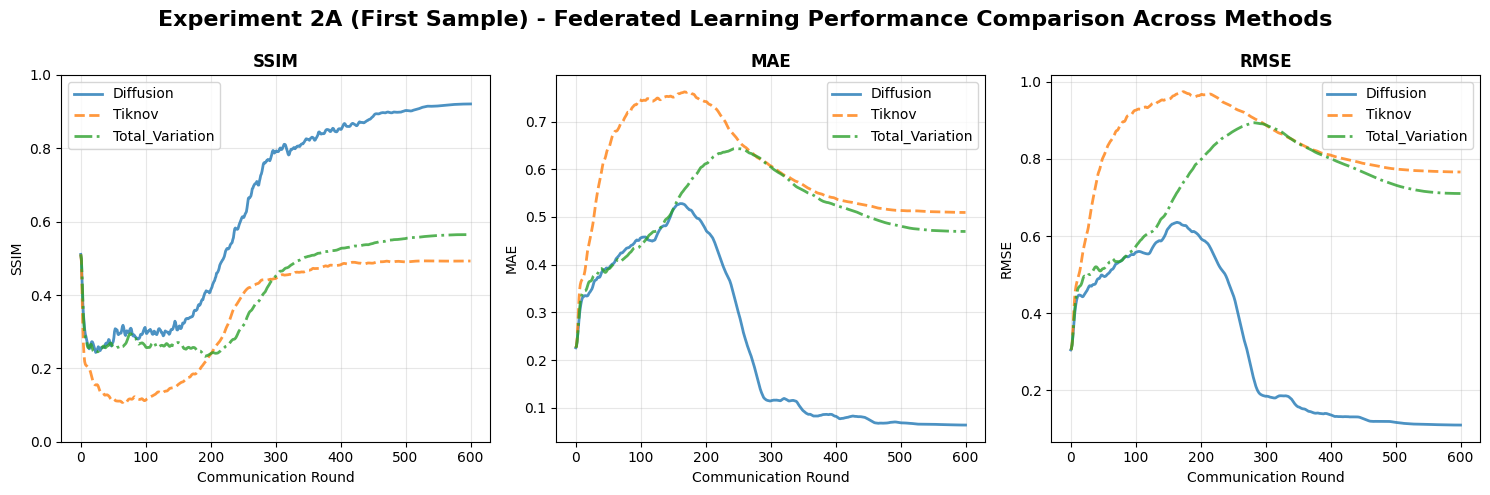

In [51]:
# Create line plots for the first sample of experiment 2A only
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Experiment 2A (First Sample) - Federated Learning Performance Comparison Across Methods', fontsize=16, fontweight='bold')

# Colors for each method
method_colors = {
    'Diffusion': '#1f77b4',
    'Tiknov': '#ff7f0e', 
    'Total_Variation': '#2ca02c'
}

# Line styles for variety
method_styles = {
    'Diffusion': '-',
    'Tiknov': '--',
    'Total_Variation': '-.'
}
methods = ['Diffusion', 'Tiknov', 'Total_Variation']
# Dictionary to store first sample results for 2A
first_sample_results = {}

# Load the first sample (individual_runs[0]) for each method in experiment 2A
exp = '2A'
print("Loading first sample data for each method in experiment 2A:")
for method in methods:
    result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"\nMethod: {method}")
    print(f"  Pattern: hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"  Files found: {result_files}")
    
    if result_files:
        result_file = result_files[0]
        print(f"  Loading: {result_file}")
        
        with open(result_file, "rb") as f:
            result = pickle.load(f)
        
        # Get the first individual run (first sample)
        first_run = result['individual_runs'][1]['history']
        
        # Extract metrics from the first sample
        first_sample_results[method] = {}
        for metric in metrics_to_plot:
            # Extract values from tuple format: [(round, value), ...]
            metric_values = [value for _, value in first_run.metrics_centralized[metric]]
            first_sample_results[method][metric] = metric_values
            print(f"  {metric}: {len(metric_values)} values loaded")
    else:
        print(f"  ERROR: No files found for {method}")

print(f"\nMethods successfully loaded: {list(first_sample_results.keys())}")

for metric_idx, metric in enumerate(metrics_to_plot):
    ax = axes[metric_idx]
    
    # Plot each method for this metric using first sample data
    for method in methods:
        if method in first_sample_results and metric in first_sample_results[method]:
            values = first_sample_results[method][metric]
            rounds = list(range(len(values)))
            
            ax.plot(rounds, values, 
                   color=method_colors[method],
                   linestyle=method_styles[method],
                   linewidth=2,
                   label=method,
                   marker='o' if len(rounds) <= 50 else None,
                   markersize=3,
                   alpha=0.8)
    
    # Customize the subplot
    ax.set_title(f'{metric.upper()}', fontweight='bold')
    ax.set_xlabel('Communication Round')
    ax.set_ylabel(metric.upper())
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set y-axis limits based on metric type
    if metric == 'ssim':
        ax.set_ylim(0, 1)
    
    # Format axes
    ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('line_plots_2A_first_sample.png')
plt.show()


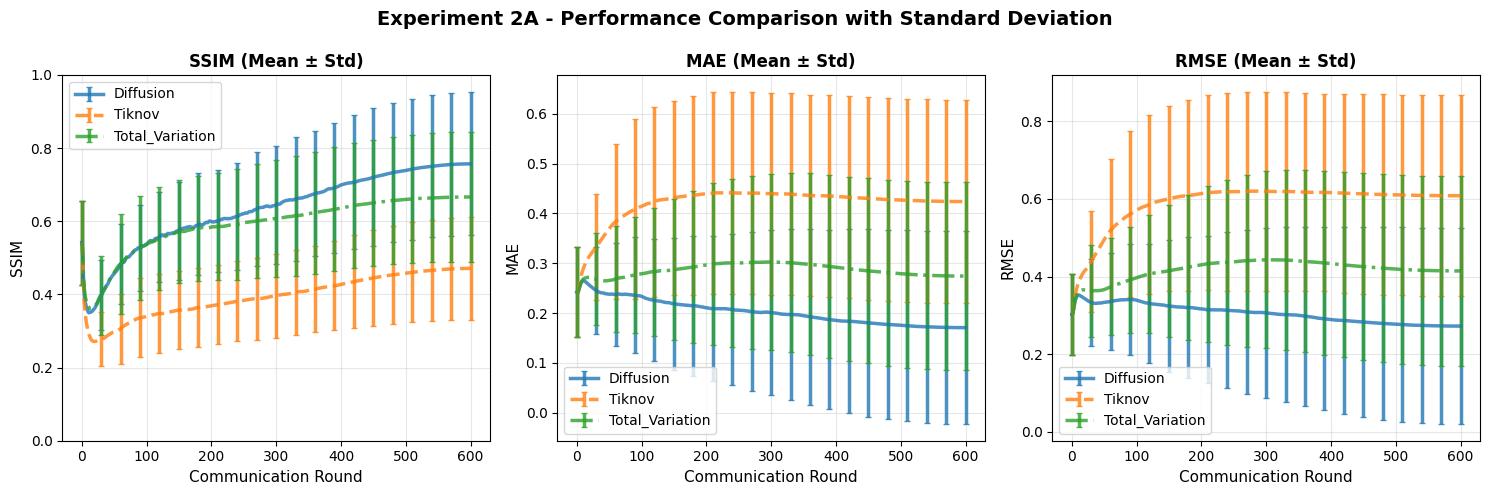

In [52]:
# Create separate plots for each experiment with standard deviation (error bars)
# This version shows mean ± std across all individual runs
for exp in experiments:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Experiment {exp} - Performance Comparison with Standard Deviation', fontsize=14, fontweight='bold')
    
    for metric_idx, metric in enumerate(metrics_to_plot):
        ax = axes[metric_idx]
        
        # Plot each method for this metric with error bars
        for method in methods:
            result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
            if result_files:
                result_file = result_files[0]
                
                with open(result_file, "rb") as f:
                    result = pickle.load(f)
                
                # Collect metric values from all individual runs
                all_runs_data = []
                for run in result['individual_runs']:
                    history = run['history']
                    if metric in history.metrics_centralized:
                        # Extract values from tuple format: [(round, value), ...]
                        metric_values = [value for _, value in history.metrics_centralized[metric]]
                        all_runs_data.append(metric_values)
                
                if all_runs_data:
                    # Convert to numpy array: shape = (num_runs, num_rounds)
                    all_runs_data = np.array(all_runs_data)
                    
                    # Calculate mean and std across runs (axis=0) for each round
                    mean_values = np.mean(all_runs_data, axis=0)
                    std_values = np.std(all_runs_data, axis=0)
                    rounds = list(range(len(mean_values)))
                    
                    # Plot mean line with error bars (std)
                    ax.errorbar(rounds, mean_values, yerr=std_values,
                               color=method_colors[method],
                               linestyle=method_styles[method],
                               linewidth=2.5,
                               label=method,
                               marker='o' if len(rounds) <= 50 else None,
                               markersize=3,
                               alpha=0.8,
                               capsize=2,
                               errorevery=max(1, len(rounds)//20))  # Show error bars every 5% of points
        
        # Customize the subplot
        ax.set_title(f'{metric.upper()} (Mean ± Std)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Communication Round', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        # Set y-axis limits based on metric type
        if metric == 'ssim':
            ax.set_ylim(0, 1)
        
        # Format axes
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


Loading first sample seismic loss data for each method in experiment 2A:

Method: Diffusion
  Pattern: hpc_result/FedAvgM_Diffusion_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl
dict_keys(['seismic_loss', 'diffusion_loss', 'mae', 'rmse', 'ssim'])
0.002847847295925021
  seismic_loss: 601 values loaded

Method: Tiknov
  Pattern: hpc_result/FedAvgM_Tiknov_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl
dict_keys(['seismic_loss', 'diffusion_loss', 'mae', 'rmse', 'ssim'])
0.014988863840699196
  seismic_loss: 601 values loaded

Method: Total_Variation
  Pattern: hpc_result/FedAvgM_Total_Variation_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Total_Variation_2A_20250808_160022/agg

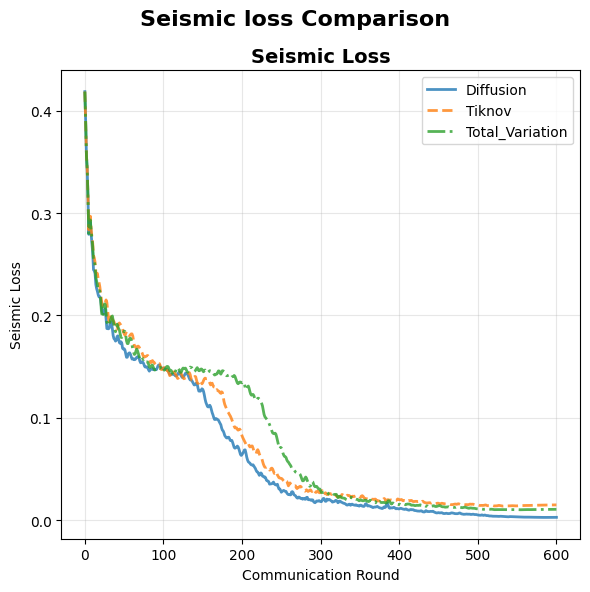

In [65]:
# Create line plots for losses from losses_centralized (first sample of experiment 2A)
# NOTE: losses_centralized contains TOTAL LOSS = seismic_loss + 0.75 * diffusion_loss (not pure seismic loss)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Seismic loss Comparison', fontsize=16, fontweight='bold')

# Colors for each method
method_colors = {
    'Diffusion': '#1f77b4',
    'Tiknov': '#ff7f0e', 
    'Total_Variation': '#2ca02c'
}

# Line styles for variety
method_styles = {
    'Diffusion': '-',
    'Tiknov': '--',
    'Total_Variation': '-.'
}

# Dictionary to store first sample seismic loss results for 2A
first_sample_losses = {}

# Load the first sample seismic loss from losses_centralized for each method in experiment 2A
exp = '2A'
print("Loading first sample seismic loss data for each method in experiment 2A:")
for method in methods:
    result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"\nMethod: {method}")
    print(f"  Pattern: hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"  Files found: {result_files}")
    
    if result_files:
        result_file = result_files[0]
        print(f"  Loading: {result_file}")
        
        with open(result_file, "rb") as f:
            result = pickle.load(f)
        
        # Get the first individual run (first sample)
        first_run = result['individual_runs'][1]['history']
        print(first_run.metrics_centralized.keys())
        loss_values = [value for _, value in first_run.metrics_centralized['seismic_loss']]
        print(loss_values[-1])
        first_sample_losses[method] = loss_values
        print(f"  seismic_loss: {len(loss_values)} values loaded")


print(f"\nMethods successfully loaded for seismic loss: {list(first_sample_losses.keys())}")

# Plot seismic loss for each method
for method in methods:
    if method in first_sample_losses:
        values = first_sample_losses[method]
        rounds = list(range(len(values)))
        
        ax.plot(rounds, values, 
               color=method_colors[method],
               linestyle=method_styles[method],
               linewidth=2,
               label=method,
               marker='o' if len(rounds) <= 50 else None,
               markersize=3,
               alpha=0.8)

# Customize the plot
ax.set_title('Seismic Loss', fontweight='bold', fontsize=14)
ax.set_xlabel('Communication Round')
ax.set_ylabel('Seismic Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# Format axes
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig('seismic_loss_2A_first_sample.png')
plt.show()


Loading first sample seismic loss data for each method in experiment 2A:

Method: Diffusion
  Pattern: hpc_result/FedAvgM_Diffusion_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl
dict_keys(['seismic_loss', 'diffusion_loss', 'mae', 'rmse', 'ssim'])
[]
0.02245841547846794
  seismic_loss: 601 values loaded

Method: Tiknov
  Pattern: hpc_result/FedAvgM_Tiknov_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl
dict_keys(['seismic_loss', 'diffusion_loss', 'mae', 'rmse', 'ssim'])
[]
0.014988863840699196
  seismic_loss: 601 values loaded

Method: Total_Variation
  Pattern: hpc_result/FedAvgM_Total_Variation_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Total_Variation_2A_20250808_16002

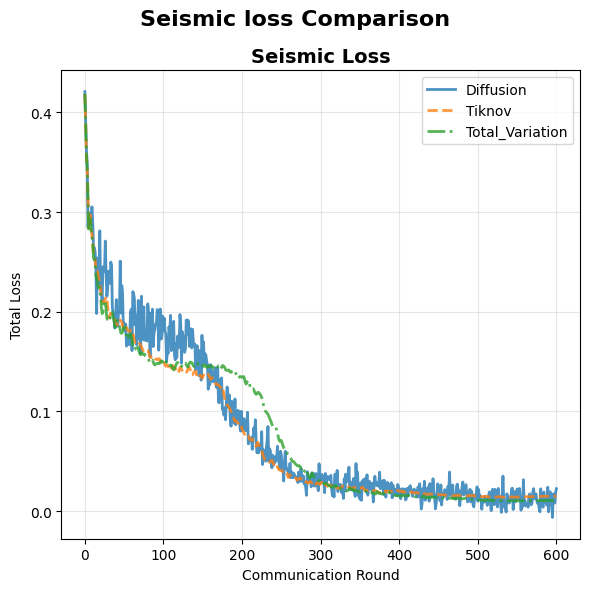

In [ ]:
# Create line plots for losses from losses_centralized (first sample of experiment 2A)
# NOTE: losses_centralized contains TOTAL LOSS = seismic_loss + 0.75 * diffusion_loss (not pure seismic loss)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Seismic loss Comparison', fontsize=16, fontweight='bold')

# Colors for each method
method_colors = {
    'Diffusion': '#1f77b4',
    'Tiknov': '#ff7f0e', 
    'Total_Variation': '#2ca02c'
}

# Line styles for variety
method_styles = {
    'Diffusion': '-',
    'Tiknov': '--',
    'Total_Variation': '-.'
}

# Dictionary to store first sample seismic loss results for 2A
first_sample_losses = {}

# Load the first sample seismic loss from losses_centralized for each method in experiment 2A
exp = '2A'
print("Loading first sample seismic loss data for each method in experiment 2A:")
for method in methods:
    result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"\nMethod: {method}")
    print(f"  Pattern: hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"  Files found: {result_files}")
    
    if result_files:
        result_file = result_files[0]
        print(f"  Loading: {result_file}")
        
        with open(result_file, "rb") as f:
            result = pickle.load(f)
        
        # Get the first individual run (first sample)
        first_run = result['individual_runs'][1]['history']
        
        loss_values = [value for _, value in first_run.losses_centralized]
        print(first_run.metrics_centralized.keys())
        print(first_run.losses_distributed)
        first_sample_losses[method] = loss_values
        print(loss_values[-1])
        print(f"  seismic_loss: {len(loss_values)} values loaded")


print(f"\nMethods successfully loaded for seismic loss: {list(first_sample_losses.keys())}")

# Plot seismic loss for each method
for method in methods:
    if method in first_sample_losses:
        values = first_sample_losses[method]
        rounds = list(range(len(values)))
        
        ax.plot(rounds, values, 
               color=method_colors[method],
               linestyle=method_styles[method],
               linewidth=2,
               label=method,
               marker='o' if len(rounds) <= 50 else None,
               markersize=3,
               alpha=0.8)

# Customize the plot
ax.set_title('Seismic Loss', fontweight='bold', fontsize=14)
ax.set_xlabel('Communication Round')
ax.set_ylabel('Total Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# Format axes
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig('Total_loss_2A_first_sample.png')
plt.show()

Loading first sample seismic loss data for each method in experiment 2A:

Method: Diffusion
  Pattern: hpc_result/FedAvgM_Diffusion_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl
  seismic_loss: 601 values loaded

Method: Tiknov
  Pattern: hpc_result/FedAvgM_Tiknov_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl
  seismic_loss: 601 values loaded

Method: Total_Variation
  Pattern: hpc_result/FedAvgM_Total_Variation_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Total_Variation_2A_20250808_160022/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Total_Variation_2A_20250808_160022/aggregated_results.pkl
  seismic_loss: 601 values loaded

Methods successfully loaded for sei

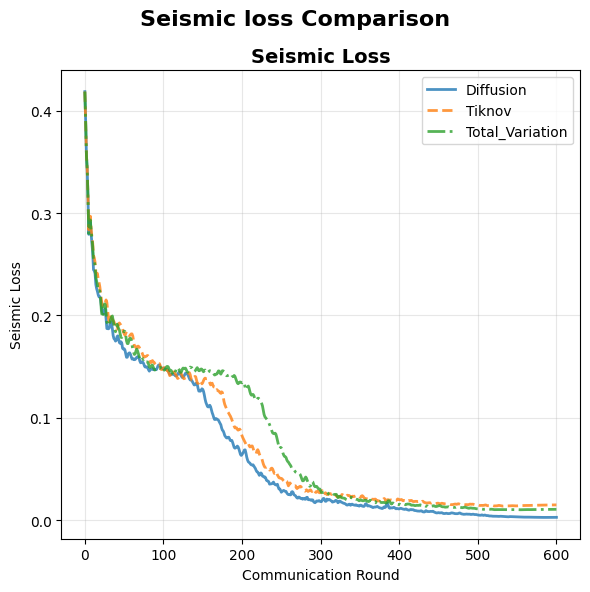

In [ ]:
# Create line plots for losses from losses_centralized (first sample of experiment 2A)
# NOTE: losses_centralized contains TOTAL LOSS = seismic_loss + 0.75 * diffusion_loss (not pure seismic loss)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Seismic loss Comparison', fontsize=16, fontweight='bold')

# Colors for each method
method_colors = {
    'Diffusion': '#1f77b4',
    'Tiknov': '#ff7f0e', 
    'Total_Variation': '#2ca02c'
}

# Line styles for variety
method_styles = {
    'Diffusion': '-',
    'Tiknov': '--',
    'Total_Variation': '-.'
}

# Dictionary to store first sample seismic loss results for 2A
first_sample_losses = {}

# Load the first sample seismic loss from losses_centralized for each method in experiment 2A
exp = '2A'
print("Loading first sample seismic loss data for each method in experiment 2A:")
for method in methods:
    result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"\nMethod: {method}")
    print(f"  Pattern: hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"  Files found: {result_files}")
    
    if result_files:
        result_file = result_files[0]
        print(f"  Loading: {result_file}")
        
        with open(result_file, "rb") as f:
            result = pickle.load(f)
        
        # Get the first individual run (first sample)
        first_run = result['individual_runs'][1]['history']
        
        loss_values = [value for _, value in first_run.metrics_centralized['seismic_loss']]
        first_sample_losses[method] = loss_values
        print(f"  seismic_loss: {len(loss_values)} values loaded")


print(f"\nMethods successfully loaded for seismic loss: {list(first_sample_losses.keys())}")

# Plot seismic loss for each method
for method in methods:
    if method in first_sample_losses:
        values = first_sample_losses[method]
        rounds = list(range(len(values)))
        
        ax.plot(rounds, values, 
               color=method_colors[method],
               linestyle=method_styles[method],
               linewidth=2,
               label=method,
               marker='o' if len(rounds) <= 50 else None,
               markersize=3,
               alpha=0.8)

# Customize the plot
ax.set_title('Seismic Loss', fontweight='bold', fontsize=14)
ax.set_xlabel('Communication Round')
ax.set_ylabel('Seismic Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# Format axes
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig('seismic_loss_2A_first_sample.png')
plt.show()


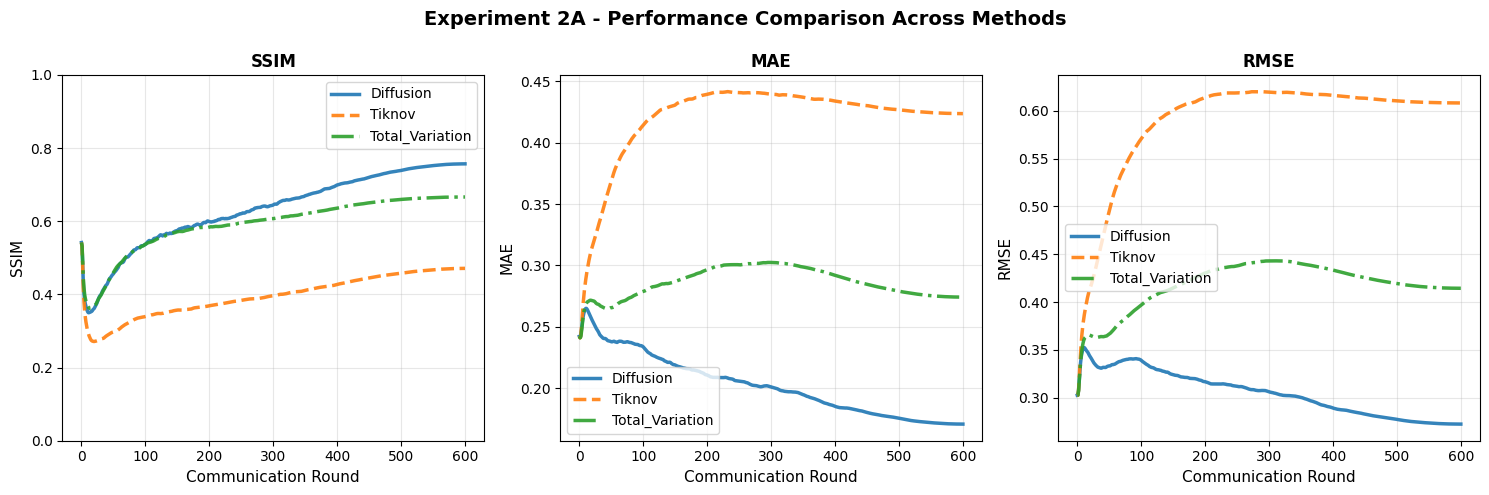

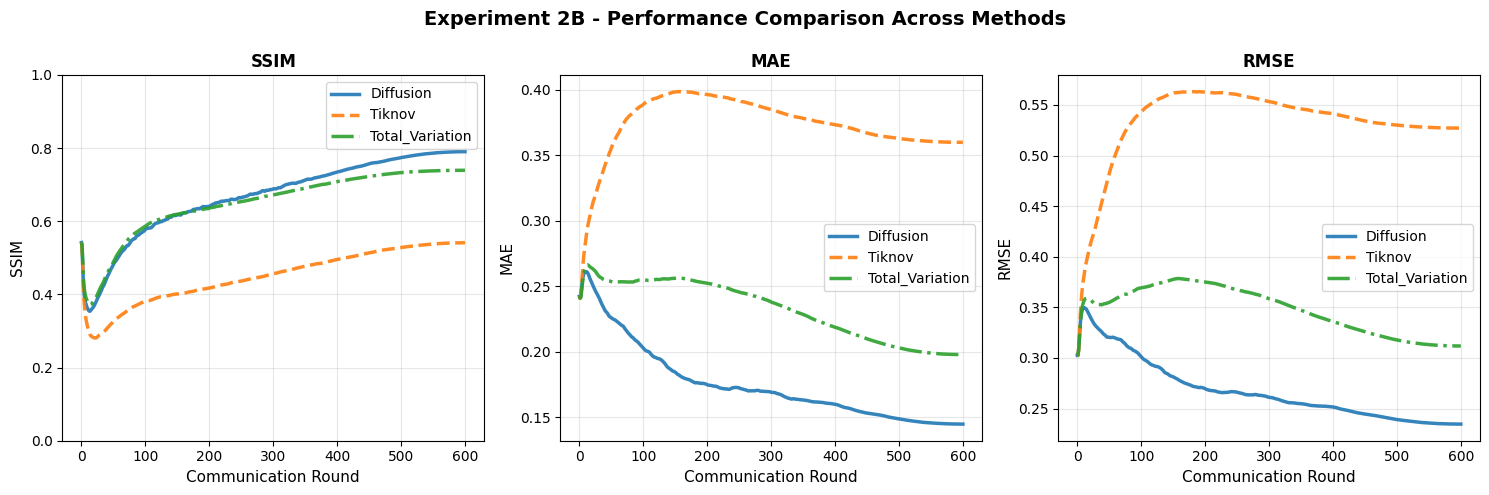

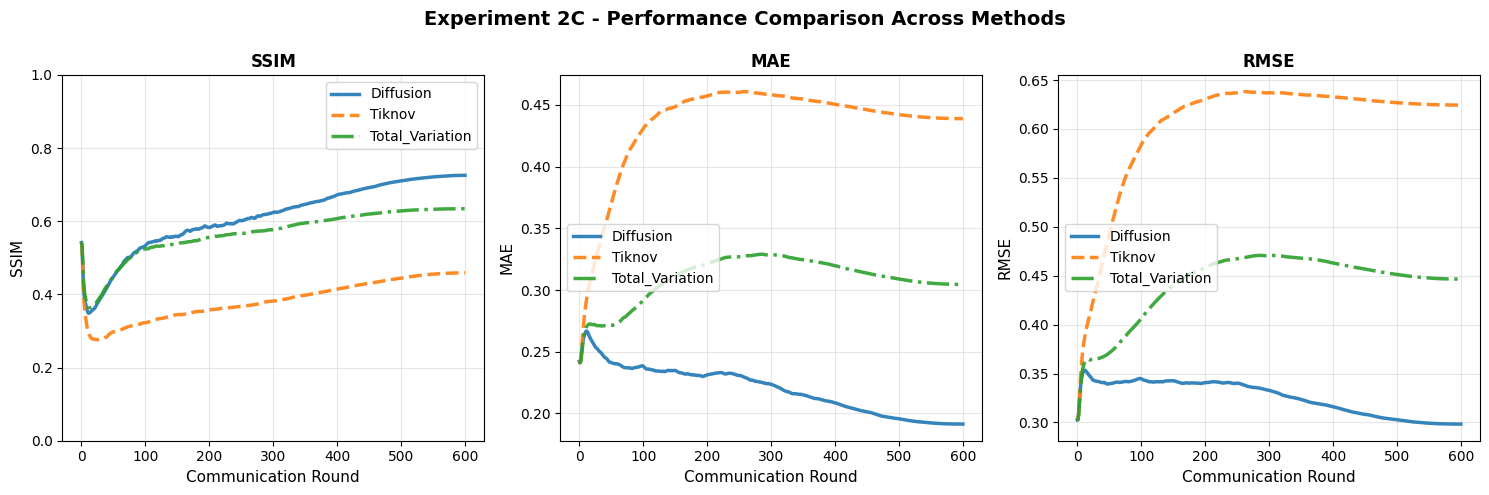

In [41]:
# Create separate plots for each experiment for better readability
for exp in experiments:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Experiment {exp} - Performance Comparison Across Methods', fontsize=14, fontweight='bold')
    
    for metric_idx, metric in enumerate(metrics_to_plot):
        ax = axes[metric_idx]
        
        # Plot each method for this metric
        for method in methods:
            if all_results[exp][method] is not None and metric in all_results[exp][method]:
                values = all_results[exp][method][metric]
                rounds = list(range(len(values)))
                
                ax.plot(rounds, values, 
                       color=method_colors[method],
                       linestyle=method_styles[method],
                       linewidth=2.5,
                       label=method,
                       marker='o' if len(rounds) <= 50 else None,
                       markersize=4,
                       alpha=0.9)
        
        # Customize the subplot
        ax.set_title(f'{metric.upper()}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Communication Round', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        # Set y-axis limits based on metric type
        if metric == 'ssim':
            ax.set_ylim(0, 1)
        
        # Format axes
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


Loading first sample seismic loss data for each method in experiment 2A:

Method: Diffusion
  Pattern: hpc_result/FedAvgM_Diffusion_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Diffusion_2A_20250806_005337/aggregated_results.pkl
  seismic_loss: 601 values loaded

Method: Tiknov
  Pattern: hpc_result/FedAvgM_Tiknov_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Tiknov_2A_20250808_160634/aggregated_results.pkl
  seismic_loss: 601 values loaded

Method: Total_Variation
  Pattern: hpc_result/FedAvgM_Total_Variation_2A_*/aggregated_results.pkl
  Files found: ['hpc_result/FedAvgM_Total_Variation_2A_20250808_160022/aggregated_results.pkl']
  Loading: hpc_result/FedAvgM_Total_Variation_2A_20250808_160022/aggregated_results.pkl
  seismic_loss: 601 values loaded

Methods successfully loaded for sei

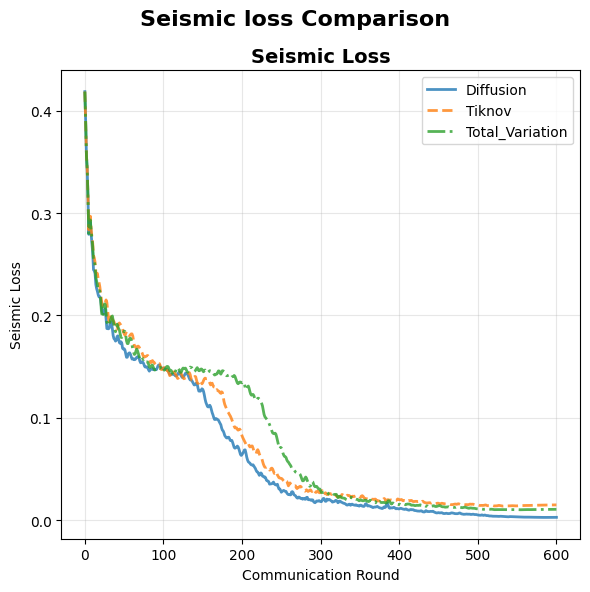

In [ ]:
# Create line plots for losses from losses_centralized (first sample of experiment 2A)
# NOTE: losses_centralized contains TOTAL LOSS = seismic_loss + 0.75 * diffusion_loss (not pure seismic loss)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Seismic loss Comparison', fontsize=16, fontweight='bold')

# Colors for each method
method_colors = {
    'Diffusion': '#1f77b4',
    'Tiknov': '#ff7f0e', 
    'Total_Variation': '#2ca02c'
}

# Line styles for variety
method_styles = {
    'Diffusion': '-',
    'Tiknov': '--',
    'Total_Variation': '-.'
}

# Dictionary to store first sample seismic loss results for 2A
first_sample_losses = {}

# Load the first sample seismic loss from losses_centralized for each method in experiment 2A
exp = '2A'
print("Loading first sample seismic loss data for each method in experiment 2A:")
for method in methods:
    result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"\nMethod: {method}")
    print(f"  Pattern: hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    print(f"  Files found: {result_files}")
    
    if result_files:
        result_file = result_files[0]
        print(f"  Loading: {result_file}")
        
        with open(result_file, "rb") as f:
            result = pickle.load(f)
        
        # Get the first individual run (first sample)
        first_run = result['individual_runs'][1]['history']
        
        loss_values = [value for _, value in first_run.metrics_centralized['seismic_loss']]
        first_sample_losses[method] = loss_values
        print(f"  seismic_loss: {len(loss_values)} values loaded")


print(f"\nMethods successfully loaded for seismic loss: {list(first_sample_losses.keys())}")

# Plot seismic loss for each method
for method in methods:
    if method in first_sample_losses:
        values = first_sample_losses[method]
        rounds = list(range(len(values)))
        
        ax.plot(rounds, values, 
               color=method_colors[method],
               linestyle=method_styles[method],
               linewidth=2,
               label=method,
               marker='o' if len(rounds) <= 50 else None,
               markersize=3,
               alpha=0.8)

# Customize the plot
ax.set_title('Seismic Loss', fontweight='bold', fontsize=14)
ax.set_xlabel('Communication Round')
ax.set_ylabel('Seismic Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# Format axes
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig('seismic_loss_2A_first_sample.png')
plt.show()


In [71]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from functools import partial

def total_variation_loss(mu):
    """Computes Total Variation Loss for the velocity map (mu)."""
    diff_x = torch.abs(mu[:, :, :, 1:] - mu[:, :, :, :-1])  # Horizontal differences
    diff_y = torch.abs(mu[:, :, 1:, :] - mu[:, :, :-1, :])  # Vertical differences
    tv_loss = torch.mean(diff_x) + torch.mean(diff_y)
    return tv_loss

def tikhonov_loss(mu):
    """Computes L2 regularization (Tikhonov) for the velocity map (mu)."""
    diff_x = mu[:, :, :, 1:] - mu[:, :, :, :-1]
    diff_y = mu[:, :, 1:, :] - mu[:, :, :-1, :]
    
    # Compute the L2 loss separately for x and y directions
    l2_loss_x = torch.mean(diff_x ** 2)
    l2_loss_y = torch.mean(diff_y ** 2)
    
    # Sum the losses from both directions
    l2_loss = l2_loss_x + l2_loss_y
    
    return l2_loss

tensor(0.0025)
tensor(0.0093)
torch.Size([70, 70])


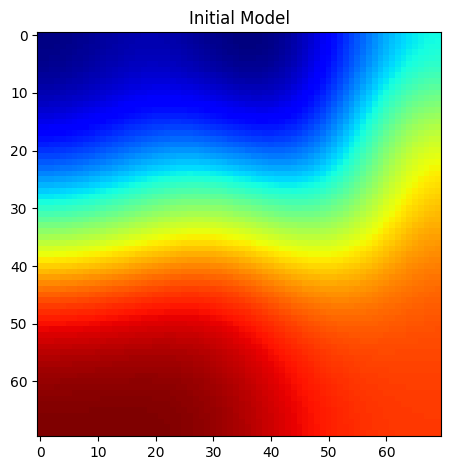

In [75]:
import matplotlib.pyplot as plt
import numpy as np

experiments = ['2A']
methods = ['Diffusion', 'Tiknov', 'Total_Variation']
for i in range(1):
    for exp in experiments:
        all_results[exp] = {}
        for method in methods:
            result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
            if result_files:
                result_file = result_files[0]
                
                with open(result_file, "rb") as f:
                    result = pickle.load(f)
                    model = result['individual_runs'][1]['final_model'][0][0][1:-1, 1:-1]
                    if method == 'Total_Variation':
                        print(total_variation_loss(torch.from_numpy(model).unsqueeze(0).unsqueeze(0)) * 0.1)
                    elif method == 'Tiknov':
                        print(tikhonov_loss(torch.from_numpy(model).unsqueeze(0).unsqueeze(0)) * 0.1)
                    plt.imshow(model, cmap = 'jet')
                    plt.title(f"Model for {exp} {method}")
                    plt.tight_layout()
                    plt.savefig(f"FedAvgM_{method}_{exp}_*_model.png")

# show the ground truth and the initial model
gt_path = "dataset/velocity_model/CF.npy"
gt = np.load(gt_path)[1,0]
plt.imshow(gt, cmap = 'jet')
plt.title(f"Ground Truth")
plt.tight_layout()
plt.savefig(f"gt.png")

from scripts.data_utils.data_trans import prepare_initial_model
import torch
initial_model = prepare_initial_model(torch.from_numpy(gt), initial_type='smoothed', sigma=10)
print(initial_model.shape)
plt.imshow(initial_model.cpu().numpy(), cmap = 'jet')
plt.title(f"Initial Model")
plt.tight_layout()
plt.savefig(f"initial_model.png")

In [ ]:
# VERIFICATION: What exactly is stored in losses_centralized for each method?
print("=== VERIFICATION OF losses_centralized CONTENT ===")
print("Based on code analysis:")
print()

print("📍 CLIENT TRAINING (flwr_client.py lines 110-118):")
print("   • Diffusion:      total_loss = seismic_loss + 0.75 * diffusion_loss")
print("   • Total_Variation: total_loss = seismic_loss + 0.1 * total_variation_loss")  
print("   • Tiknov:         total_loss = seismic_loss + 0.1 * tikhonov_loss")
print("   • None:           total_loss = seismic_loss")
print()

print("📍 SERVER EVALUATION (flwr_evaluation.py line 57, 84):")
print("   • All methods:    total_loss = seismic_loss + 0.75 * diffusion_loss")
print("   • Returns:        (total_loss.item(), metrics_dict)")
print()

print("⚠️  IMPORTANT DISCREPANCY:")
print("   • Client training uses method-specific regularization")
print("   • Server evaluation ONLY adds diffusion_loss (even for TV/Tiknov)")
print("   • Server diffusion_loss = 0 for TV/Tiknov methods")
print()

print("🔍 WHAT losses_centralized ACTUALLY CONTAINS:")
print("   • Diffusion:      seismic_loss + 0.75 * diffusion_loss (from server eval)")
print("   • Total_Variation: seismic_loss + 0 (TV regularization NOT in server eval)")
print("   • Tiknov:         seismic_loss + 0 (Tiknov regularization NOT in server eval)")
print()

print("✅ CONCLUSION:")
print("   losses_centralized contains the SERVER EVALUATION total loss")
print("   NOT the CLIENT TRAINING total loss with proper regularization")
print("   For TV/Tiknov: losses_centralized ≈ pure seismic_loss")
print("   For Diffusion: losses_centralized = seismic_loss + 0.75 * diffusion_loss")
print("="*80)


In [ ]:
# Let's check if client-returned metrics are stored somewhere
exp = '2A'
methods_to_check = ['Diffusion', 'Total_Variation', 'Tiknov']

for method in methods_to_check:
    result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
    if result_files:
        result_file = result_files[0]
        print(f"\n=== {method} METHOD ===")
        
        with open(result_file, "rb") as f:
            result = pickle.load(f)
        
        # Check first individual run
        first_run = result['individual_runs'][0]['history']
        
        print(f"Available in history object:")
        print(f"  - losses_centralized: {type(first_run.losses_centralized)} (length: {len(first_run.losses_centralized)})")
        print(f"  - metrics_centralized keys: {list(first_run.metrics_centralized.keys())}")
        
        # Check if there are other attributes that might store client metrics
        print(f"  - All history attributes: {[attr for attr in dir(first_run) if not attr.startswith('_')]}")
        
        # Show first few values
        if len(first_run.losses_centralized) > 0:
            print(f"  - losses_centralized[0:3]: {first_run.losses_centralized[:3]}")
        
        if 'total_loss' in first_run.metrics_centralized:
            print(f"  - metrics_centralized['total_loss'][0:3]: {first_run.metrics_centralized['total_loss'][:3]}")
        else:
            print(f"  - 'total_loss' NOT found in metrics_centralized")
            
        print(f"  - seismic_loss[0:3]: {first_run.metrics_centralized['seismic_loss'][:3]}")
        print(f"  - diffusion_loss[0:3]: {first_run.metrics_centralized['diffusion_loss'][:3]}")


In [ ]:
# Let's examine the complete Flower history object structure
exp = '2A'
method = 'Diffusion'  # Start with one method

result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
if result_files:
    result_file = result_files[0]
    print(f"Loading: {result_file}")
    
    with open(result_file, "rb") as f:
        result = pickle.load(f)
    
    # Get the first individual run
    first_run = result['individual_runs'][0]['history']
    
    print(f"\n=== COMPLETE FLOWER HISTORY STRUCTURE ===")
    print(f"Type: {type(first_run)}")
    print(f"All attributes: {[attr for attr in dir(first_run) if not attr.startswith('_')]}")
    
    # Check all possible places where client metrics might be stored
    for attr in ['losses_centralized', 'losses_distributed', 'metrics_centralized', 'metrics_distributed']:
        if hasattr(first_run, attr):
            attr_value = getattr(first_run, attr)
            print(f"\n{attr}:")
            print(f"  Type: {type(attr_value)}")
            if hasattr(attr_value, 'keys'):
                print(f"  Keys: {list(attr_value.keys())}")
            elif isinstance(attr_value, (list, tuple)) and len(attr_value) > 0:
                print(f"  Length: {len(attr_value)}")
                print(f"  First few items: {attr_value[:3]}")
            else:
                print(f"  Content: {attr_value}")
        else:
            print(f"\n{attr}: NOT FOUND")
    
    # Specifically check if total_loss is stored somewhere
    print(f"\n=== SEARCHING FOR CLIENT-RETURNED total_loss ===")
    if hasattr(first_run, 'metrics_distributed'):
        print(f"metrics_distributed type: {type(first_run.metrics_distributed)}")
        if isinstance(first_run.metrics_distributed, dict) and first_run.metrics_distributed:
            print(f"metrics_distributed keys: {list(first_run.metrics_distributed.keys())}")
            for key, value in first_run.metrics_distributed.items():
                if 'total_loss' in str(key).lower():
                    print(f"  Found total_loss related: {key} -> {value[:3] if len(value) > 2 else value}")
else:
    print(f"No files found for {method} {exp}")


In [21]:
# Debug: Check what files are available for experiment 2A
import os
print("Checking available files for experiment 2A:")
print("Directory contents of hpc_result/:")

if os.path.exists("hpc_result"):
    dirs = [d for d in os.listdir("hpc_result") if "2A" in d]
    print(f"Directories containing '2A': {dirs}")
    
    for method in ['Diffusion', 'Tiknov', 'Total_Variation']:
        pattern = f"hpc_result/FedAvgM_{method}_2A_*"
        matching_dirs = glob.glob(pattern)
        print(f"\n{method}:")
        print(f"  Pattern: {pattern}")
        print(f"  Matching directories: {matching_dirs}")
        
        for dir_path in matching_dirs:
            aggregated_file = os.path.join(dir_path, "aggregated_results.pkl")
            print(f"  aggregated_results.pkl exists: {os.path.exists(aggregated_file)}")
else:
    print("hpc_result directory does not exist")


Checking available files for experiment 2A:
Directory contents of hpc_result/:
Directories containing '2A': ['FedAvgM_Total_Variation_2A_20250808_160022', 'FedAvgM_Tiknov_2A_20250808_160634', 'FedAvgM_Diffusion_2A_20250806_005337']

Diffusion:
  Pattern: hpc_result/FedAvgM_Diffusion_2A_*
  Matching directories: ['hpc_result/FedAvgM_Diffusion_2A_20250806_005337']
  aggregated_results.pkl exists: True

Tiknov:
  Pattern: hpc_result/FedAvgM_Tiknov_2A_*
  Matching directories: ['hpc_result/FedAvgM_Tiknov_2A_20250808_160634']
  aggregated_results.pkl exists: True

Total_Variation:
  Pattern: hpc_result/FedAvgM_Total_Variation_2A_*
  Matching directories: ['hpc_result/FedAvgM_Total_Variation_2A_20250808_160022']
  aggregated_results.pkl exists: True


In [22]:
# IMPORTANT CLARIFICATION ABOUT LOSSES vs METRICS:
print("=== UNDERSTANDING THE DIFFERENCE ===")
print("1. losses_centralized: Contains TOTAL LOSS = seismic_loss + 0.75 * diffusion_loss")
print("2. metrics_centralized['seismic_loss']: Contains PURE seismic loss only")
print("3. For pure seismic data fitting performance, use metrics_centralized['seismic_loss']")
print("4. For overall optimization objective, use losses_centralized")
print("\nSource: flwr_evaluation.py line 57: total_loss = 0.75 * diffusion_loss + seismic_loss")
print("        flwr_evaluation.py line 84: return total_loss.item(), {'seismic_loss': seismic_loss.item(), ...}")
print("\n" + "="*60)


=== UNDERSTANDING THE DIFFERENCE ===
1. losses_centralized: Contains TOTAL LOSS = seismic_loss + 0.75 * diffusion_loss
2. metrics_centralized['seismic_loss']: Contains PURE seismic loss only
3. For pure seismic data fitting performance, use metrics_centralized['seismic_loss']
4. For overall optimization objective, use losses_centralized

Source: flwr_evaluation.py line 57: total_loss = 0.75 * diffusion_loss + seismic_loss
        flwr_evaluation.py line 84: return total_loss.item(), {'seismic_loss': seismic_loss.item(), ...}



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scripts.pde_solvers.pde_solver import 
experiments = ['2A']
methods = ['Diffusion', 'Tiknov', 'Total_Variation']
for i in range(1):
    for exp in experiments:
        all_results[exp] = {}
        for method in methods:
            result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/aggregated_results.pkl")
            if result_files:
                result_file = result_files[0]
                
                with open(result_file, "rb") as f:
                    result = pickle.load(f)
                    model = result['individual_runs'][1]['final_model'][0][0][1:-1, 1:-1]
                    print(model.shape)
                    
                    
                    

(70, 70)
(70, 70)
(70, 70)


Loading first sample seismic loss data for each method in experiment 2A:
  Loading: hpc_result/FedAvgM_Diffusion_2A_20250806_005337/intermediate_results/CF_0_result.pkl
History (loss, centralized):
	round 0: 0.20198488235473633
	round 1: 0.1618117243051529
	round 2: 0.13788223266601562
	round 3: 0.1452886164188385
	round 4: 0.12902989983558655
	round 5: 0.12711070477962494
	round 6: 0.14168384671211243
	round 7: 0.15198303759098053
	round 8: 0.18226297199726105
	round 9: 0.16304048895835876
	round 10: 0.13863611221313477
	round 11: 0.13067753612995148
	round 12: 0.14354772865772247
	round 13: 0.12285551428794861
	round 14: 0.1267860382795334
	round 15: 0.13639621436595917
	round 16: 0.15248501300811768
	round 17: 0.12227451801300049
	round 18: 0.15820246934890747
	round 19: 0.20558993518352509
	round 20: 0.12459809333086014
	round 21: 0.13778142631053925
	round 22: 0.12285910546779633
	round 23: 0.11551978439092636
	round 24: 0.12174732983112335
	round 25: 0.15375138819217682
	round 26

/tmp/ipykernel_1734483/2936548202.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


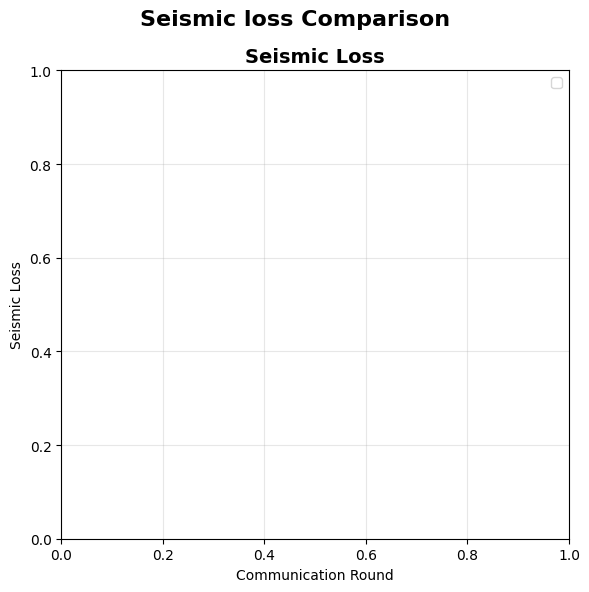

In [64]:
# Create line plots for losses from losses_centralized (first sample of experiment 2A)
# NOTE: losses_centralized contains TOTAL LOSS = seismic_loss + 0.75 * diffusion_loss (not pure seismic loss)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Seismic loss Comparison', fontsize=16, fontweight='bold')

# Colors for each method
method_colors = {
    'Diffusion': '#1f77b4',
    'Tiknov': '#ff7f0e', 
    'Total_Variation': '#2ca02c'
}

# Line styles for variety
method_styles = {
    'Diffusion': '-',
    'Tiknov': '--',
    'Total_Variation': '-.'
}

# Dictionary to store first sample seismic loss results for 2A
first_sample_losses = {}

# Load the first sample seismic loss from losses_centralized for each method in experiment 2A
exp = '2A'
print("Loading first sample seismic loss data for each method in experiment 2A:")
for method in methods:
    result_files = glob.glob(f"hpc_result/FedAvgM_{method}_{exp}_*/intermediate_results/CF_0_result.pkl")
    
    if result_files:
        result_file = result_files[0]
        print(f"  Loading: {result_file}")
        
        with open(result_file, "rb") as f:
            result = pickle.load(f)
        
        print(result['history'])


print(f"\nMethods successfully loaded for seismic loss: {list(first_sample_losses.keys())}")

# Plot seismic loss for each method
for method in methods:
    if method in first_sample_losses:
        values = first_sample_losses[method]
        rounds = list(range(len(values)))
        
        ax.plot(rounds, values, 
               color=method_colors[method],
               linestyle=method_styles[method],
               linewidth=2,
               label=method,
               marker='o' if len(rounds) <= 50 else None,
               markersize=3,
               alpha=0.8)

# Customize the plot
ax.set_title('Seismic Loss', fontweight='bold', fontsize=14)
ax.set_xlabel('Communication Round')
ax.set_ylabel('Seismic Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# Format axes
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig('seismic_loss_2A_first_sample.png')
plt.show()
